### **Introduction**

This notebook cover the model construction and training of an image captioning model using Flickr8k dataset

The outline is:
1. Loading and extracting image features
2. Loading and processing captions
3. Extract GloVe embeddings
4. Data generator to prepare input X[i] and target Y[i]
5. Define and train model

### **Environmnet**

In [ ]:
import os, re
import numpy as np


from PIL import Image
import matplotlib.pyplot as plt

In [126]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

tf.__version__

'2.18.0'

In [63]:
!python --version

Python 3.10.12


In [77]:
def show_image(path: str):
    try:
        plt.figure(figsize=(15, 15))
        plt.imshow(Image.open(path))
        plt.axis('off')
        plt.show()
    except:
        print("Image not found")

### **Loading Dataset**

The original dataset suggests a default split for training, test and validation. The same split is kept here. 

In [4]:
# Paths
dataset_dir = "flickr8k_dataset"

def load_text(filename):
    file = open(filename, 'r')
    text = file.read()
    text = text.split('\n')
    file.close()
    return text

train_imgs = load_text(os.path.join(dataset_dir, "Flickr_8k.trainImages.txt"))
test_imgs = load_text(os.path.join(dataset_dir, "Flickr_8k.testImages.txt"))
dev_imgs = load_text(os.path.join(dataset_dir, "Flickr_8k.devImages.txt"))

train_imgs = [x for x in train_imgs if x != '']
test_imgs = [x for x in test_imgs if x != '']
dev_imgs = [x for x in dev_imgs if x != '']

print("Number of images in training set: ", len(train_imgs))
print("Number of images in test set: ", len(test_imgs))
print("Number of images in dev set: ", len(dev_imgs))

Number of images in training set:  6000
Number of images in test set:  1000
Number of images in dev set:  1000


### **Training Data Pipeline**

We will build the pipeline for our deep learning architecture in two phases ......

#### **1. Caption Text Preprocessing**

This phase covers:
* Convert sentences into lowercase
* Remove special characters, numbers present in the text and extra spaces
* Remove words with length to focus on more meaningful, context-rich words
* Add a starting and an ending tag to each caption to helps the model understand where captions begin and end
* Converts words in the caption into numerical tokens using a predefined vocabulary
* Pads all captions to a uniform length to ensure that all captions in a batch have the same length

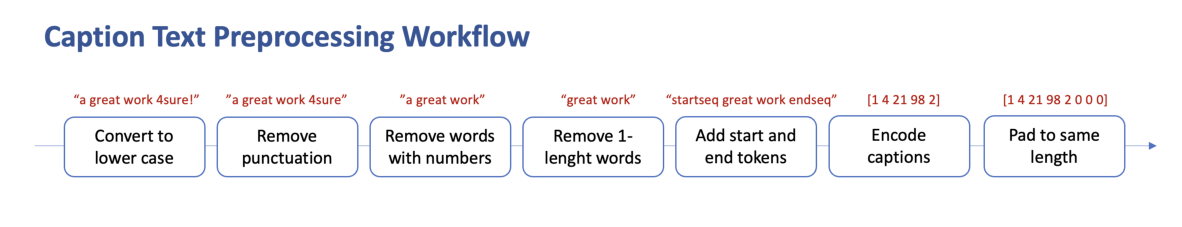

In [78]:
show_image("src/caption_preprocessing.png")

When loading the caption file, the captions are reorganized into a dictionary, where the image id serves as the key and a list of five captions corresponds to the value

In [95]:
# Load Captions
captions_file = "Flickr8k.token.txt"
captions_path = os.path.join(dataset_dir, captions_file)

def load_captions(filepath):
    captions = {}
    with open(filepath, 'r') as f:
        for line in f:
            image_id, caption = line.strip().split('\t')
            image_id = image_id.split('#')[0]
            if image_id not in captions:
                captions[image_id] = []
            captions[image_id].append(caption)
    return captions

captions_dictionary = load_captions(captions_path)
captions_dictionary['1000268201_693b08cb0e.jpg']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [96]:
# Cleaning Captions
def clean_text(text):
    text = " ".join([word.lower() for word in text.split() if len(word) > 1])
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = "startseq " + text + " endseq"
    return text.lower()

for key, captions in captions_dictionary.items():
    for i, caption in enumerate(captions):
        captions[i] = clean_text(caption)

captions_dictionary['1000268201_693b08cb0e.jpg']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

For tokenizing captions and setting the vocabulary size, I rely on Keras's built-in tokenizer, which is easy and fast to use and integrates seamlessly with the Keras ecosystem. Pre-trained word embedding models such as GloVe, Word2Vec, or FastText can be used here to capture semantic meaning and relationships between words. This last approach will be tested in the future iterations

In [64]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


def flatten_captions (data_dict):
  return ([caption for key, captions in data_dict.items() for caption in captions])

def create_tokenizer(data_dict):
  captions = flatten_captions(data_dict)
  max_caption_words = max(len(caption.split()) for caption in captions)
  
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(captions)
  vocab_size = len(tokenizer.word_index) + 1

  return (tokenizer, vocab_size, max_caption_words)

In [71]:
# Fit a Keras tokenizer given caption descriptions
tokenizer, vocab_size, max_caption_words = create_tokenizer(captions_dictionary)

# Display first 10 words the results
print("Word Index (first 10 words):", dict(list(tokenizer.word_index.items())[:10]))
print("Vocabulary Size:", vocab_size)
print("Maximum Caption Length:", max_caption_words)

Word Index (first 10 words): {'startseq': 1, 'endseq': 2, 'in': 3, 'the': 4, 'on': 5, 'is': 6, 'and': 7, 'dog': 8, 'with': 9, 'man': 10}
Vocabulary Size: 8774
Maximum Caption Length: 34


#### **2. Images Preprocessing**

This phase cover the extraction of image feature maps using InceptionV3. The reason behind using InceptionV3 as the pre-trained CNN came from identify this model as popular for image captioning problems in the literature. 

The convolutional layers in InceptionV3 produce compact, high-dimensional feature maps that summarize the image content. Another significant reason for using a pre-trained model is to reduce training time and improve generalization, as the model has already learned to extract meaningful features.

In [72]:
# list of images
def subset_image_name (filename):
  data = []
  
  with open(filename, "r") as fp:
    text = fp.read()
    lines = text.split ('\n')
    for line in lines:
      if (len(line) < 1):
        continue
      image_name = line.split ('.')[0]
      data.append (image_name)

    return (set(data))  

training_image_name_file = "flickr8k_dataset/Flickr_8k.trainImages.txt"
training_image_names = subset_image_name (training_image_name_file)

To use InceptionV3, first let's prepare the images for input into the InceptionV3 model. Then, creates a new model that takes an image as input and outputs the feature map produced by the last convolutional layer.

I remove the classifier part (the fully connected layers) to isolate extracting features process.

In [79]:
# Preprocesses each image as input for InceptionV3 model
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299)) # default input size for InceptionV3
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img, image_path

# Load the InceptionV3 model without classification layer
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')

# Create a new model that outputs feature maps from the convolutional base
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Instead of processing images through InceptionV3 repeatedly during captioning model training, the extracted features are precomputed and stored as .npy files. This idea was taken from liteature, claiming reduction in computation time and memory usage during training. The feature extraction pipeline overview is:

1. Image Paths → Create TensorFlow Dataset
2. Load and Preprocess Images → Using load_image
3. Extract Features → Using image_features_extract_model
4. Save Features → As .npy files for later use

In [82]:
from tqdm import tqdm
import numpy as np

image_dir = "flickr8k_dataset/Flicker8k_Dataset/"
training_image_paths = [image_dir + name + '.jpg' for name in training_image_names]
encode_train = sorted(set(training_image_paths))

# Create batch TensorFlow dataset
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train) 
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(16)

# Extract features over each dataset and saving
features_dir = "flickr8k_dataset/image_features"
for img, path in tqdm(image_dataset):
  batch_features = image_features_extract_model(img)
  batch_features = tf.reshape(batch_features,(batch_features.shape[0], -1, batch_features.shape[3]))

  for bf, p in zip(batch_features, path):
    os.makedirs(features_dir, exist_ok=True)
    base_name = os.path.basename(p.numpy().decode("utf-8"))
    path_of_feature = os.path.join(features_dir, base_name.replace(".jpg", ".npy"))
    np.save(path_of_feature, bf.numpy())

100%|██████████| 375/375 [08:18<00:00,  1.33s/it]


 The .npy files  contain high-level feature maps, not human-readable images. These feature maps represent the abstract features extracted by the model, such as edges, textures, and object parts, which can be visualized as heatmaps or grids.

Feature map has a shape of (64, 2048), it represents 64 spatial locations (flattened grid of height × width) with 2048 channels. To visualize this data, we can reshape it into a 2D spatial grid if we know the dimensions of the feature map.

For InceptionV3, the last convolutional layer outputs a feature map with 8x8 dimension with 2048 channels, so the shape of the feature map for a single image is: (8, 8, 2048).

Feature Map Shape: (64, 2048)
Reshaped Feature Map Shape: (8, 8, 2048)


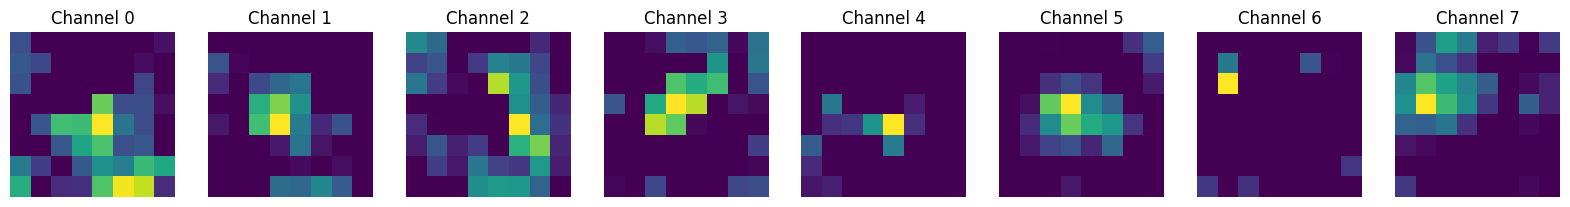

In [89]:
# Load the .npy file
feature_map = np.load("flickr8k_dataset/image_features/667626_18933d713e.npy")

reshaped_feature_map = feature_map.reshape((8, 8, 2048))
print("Feature Map Shape:", feature_map.shape)
print("Reshaped Feature Map Shape:", reshaped_feature_map.shape)  


# Visualize multiple channels
num_channels_to_display = 8
fig, axes = plt.subplots(1, num_channels_to_display, figsize=(20, 5))

for i in range(num_channels_to_display):
    ax = axes[i]
    channel_data = reshaped_feature_map[:, :, i]
    channel_data_normalized = (channel_data - channel_data.min()) / (channel_data.max() - channel_data.min())
    ax.imshow(channel_data_normalized, cmap="viridis")
    ax.axis("off")
    ax.set_title(f"Channel {i}")

plt.show()

These feature maps show the activation patterns of individual filters (channels) in the last convolutional layer. Yellow areas in the feature maps indicate strong activations for that filter, meaning that the filter has identified a feature of interest in that region while dark purple areas represent low or no activations. These maps provide insights into the network's internal representation of the image, helping us understand what it "sees."

#### **3. Data Setup for Model Input**

Pre-processed captions and images is done, now let's setup the input data for the model as following:

* A train_X array consists of file paths
* A train_y array contains properly padded captions, ready for the model
* The tf.data.Dataset pipeline ensures efficient data loading, shuffling, batching, and prefetching

First, let's go through every training image and its matching captions to prepare the training data

In [102]:
# Returns the subset of the data dictionary given the image names
def subset_data_dict (captions_dictionary, image_names):
  dict = { image_name:captions for image_name, captions in captions_dictionary.items() if image_name in image_names}
  return (dict)

training_dict = subset_data_dict (captions_dictionary, train_imgs)
print("Number of images in training set: ", len(training_dict))

Number of images in training set:  6000


Now let's converts image paths (X) and padded captions (y) into NumPy arrays to align with your subsequent TensorFlow Dataset setup. As this function is very critical I decided to document it properly.

In [157]:
def data_prep(captions_dictionary, tokenizer, max_length, image_feature_dir):
    """
    Prepare the training data as NumPy arrays for TensorFlow Dataset.

    Args:
        captions_dictionary (dict): A dictionary where keys are image file names and values are lists of captions.
        tokenizer (Tokenizer): Tokenizer fitted on the captions.
        max_length (int): Maximum length for caption sequences (after padding).
        image_feature_dir (str): Directory path where the image files are stored.

    Returns:
        np.array, np.array: Arrays containing image paths and padded captions.
    """
    X, y = [], []

    for image_name, captions in captions_dictionary.items():
        image_path = f"{image_feature_dir}{image_name}"

        for caption in captions:
            word_idxs = tokenizer.texts_to_sequences([caption])[0]
            pad_idxs = pad_sequences([word_idxs], maxlen=max_length, padding='post')[0]
            X.append(image_path)
            y.append(pad_idxs)

    return np.array(X), np.array(y)

image_feature_dir = "flickr8k_dataset/image_features/"
train_X, train_y = data_prep(training_dict, tokenizer, max_caption_words, image_feature_dir)
print("Training data shapes:", train_X.shape, train_y.shape)
print(f"Example image path: {train_X[0].tolist()}")
print(f"Example caption sequence {train_y[0].tolist()}")


Training data shapes: (30000,) (30000, 34)
Example image path: flickr8k_dataset/image_features/1000268201_693b08cb0e.jpg
Example caption sequence [1, 41, 3, 89, 169, 6, 118, 52, 395, 11, 392, 3, 27, 5195, 692, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


Now let's create the Tensorflow datasets. The dataset loads the pre-processed encoded image vectors that were saved earlier

In [160]:
# Load preprocessed image features
def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8').split('.')[0] + '.npy')
    return img_tensor, cap

# Create TensorFlow Dataset
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE) # load the numpy files in parallel

# Shuffle and batch the dataset
BATCH_SIZE = 64
BUFFER_SIZE = 1000
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

# Example
for batch in dataset.take(1):
    img_tensors, captions = batch
    print("Image Tensor Shape:", img_tensors.shape)
    print("Captions Shape:", captions.shape)

Image Tensor Shape: (64, 64, 2048)
Captions Shape: (64, 34)


The Image Tensor Shape is: (64, 64, 2048), let's break it down:

* 64: Batch size
* 64: spatial resolution of the extracted feature maps
* 2048: The depth of the feature maps (channels)

And Caption Shape represents batch_size x max_caption_words

#### **4. Defining the Image Captioning Model**

The model is composed of four key components:

1. **Encoder**: The image encoding is pre-processed using a pre-trained Inception model, so the Encoder is relatively simple. It includes a Linear layer that processes the pre-encoded image features and forwards them to the Decoder.

2. **Sequence Decoder**: A recurrent neural network, implemented with LSTMs or GRUs, serves as the Sequence Decoder. Before being input into this module, captions are passed through an Embedding layer.

3. **Attention Mechanism**: While the Decoder generates each word in the output sequence, the Attention module directs focus to the most relevant parts of the image to produce the appropriate word.

4. **Sentence Generator**: This component comprises a few Linear layers, which process the Decoder's output to compute a probability distribution over the vocabulary for each word position in the predicted caption.


In [161]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, features, hidden):
    # features(CNN_encoder output) shape == (batch_size, 64, embedding_dim)

    # hidden shape == (batch_size, hidden_size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
    hidden_with_time_axis = tf.expand_dims(hidden, 1)

    # attention_hidden_layer shape == (batch_size, 64, units)
    attention_hidden_layer = (tf.nn.tanh(self.W1(features) +
                                         self.W2(hidden_with_time_axis)))

    # score shape == (batch_size, 64, 1)
    # This gives you an unnormalized score for each image feature.
    score = self.V(attention_hidden_layer)

    # attention_weights shape == (batch_size, 64, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * features
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

class CNN_Encoder(tf.keras.Model):
    # Since you have already extracted the features and dumped it
    # This encoder passes those features through a Fully connected layer
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        # shape after fc == (batch_size, 64, embedding_dim)
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x

class RNN_Decoder(tf.keras.Model):
  def __init__(self, embedding_dim, units, vocab_size):
    super(RNN_Decoder, self).__init__()
    self.units = units

    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc1 = tf.keras.layers.Dense(self.units)
    self.fc2 = tf.keras.layers.Dense(vocab_size)

    self.attention = BahdanauAttention(self.units)

  def call(self, x, features, hidden):
    # defining attention as a separate model
    context_vector, attention_weights = self.attention(features, hidden)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # shape == (batch_size, max_length, hidden_size)
    x = self.fc1(output)

    # x shape == (batch_size * max_length, hidden_size)
    x = tf.reshape(x, (-1, x.shape[2]))

    # output shape == (batch_size * max_length, vocab)
    x = self.fc2(x)

    return x, state, attention_weights

  def reset_state(self, batch_size):
    return tf.zeros((batch_size, self.units))

In [162]:
embedding_dim = 256
units = 512
vocab_size = vocab_size
num_steps = len(train_X) // BATCH_SIZE
# Shape of the vector extracted from InceptionV3 is (64, 2048)
# These two variables represent that vector shape
features_shape = 2048
attention_features_shape = 64

encoder = CNN_Encoder(embedding_dim)
decoder = RNN_Decoder(embedding_dim, units, vocab_size)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

loss_plot = []
@tf.function
def train_step(img_tensor, target):
  loss = 0

  # initializing the hidden state for each batch
  # because the captions are not related from image to image
  hidden = decoder.reset_state(batch_size=target.shape[0])

  dec_input = tf.expand_dims([tokenizer.word_index['startseq']] * target.shape[0], 1)

  with tf.GradientTape() as tape:
      features = encoder(img_tensor)

      for i in range(1, target.shape[1]):
          # passing the features through the decoder
          predictions, hidden, _ = decoder(dec_input, features, hidden)

          loss += loss_function(target[:, i], predictions)

          # using teacher forcing
          dec_input = tf.expand_dims(target[:, i], 1)

  total_loss = (loss / int(target.shape[1]))

  trainable_variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, trainable_variables)

  optimizer.apply_gradients(zip(gradients, trainable_variables))

  return loss, total_loss

import time
start_epoch = 0
EPOCHS = 20

for epoch in range(start_epoch, EPOCHS):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss

        if batch % 100 == 0:
            average_batch_loss = batch_loss.numpy()/int(target.shape[1])
            print(f'Epoch {epoch+1} Batch {batch} Loss {average_batch_loss:.4f}')
    # storing the epoch end loss value to plot later
    loss_plot.append(total_loss / num_steps)

    print(f'Epoch {epoch+1} Loss {total_loss/num_steps:.6f}')
    print(f'Time taken for 1 epoch {time.time()-start:.2f} sec\n')

Epoch 1 Batch 0 Loss 2.9526
Epoch 1 Batch 100 Loss 1.6725
Epoch 1 Batch 200 Loss 1.5317
Epoch 1 Batch 300 Loss 1.2308
Epoch 1 Batch 400 Loss 1.1491
Epoch 1 Loss 1.440394
Time taken for 1 epoch 965.97 sec

Epoch 2 Batch 0 Loss 1.2043
Epoch 2 Batch 100 Loss 1.1716


Then use the Training List text file to select the subset of images to be used for training from our full dataset.